# SUNSET BAY HYDROPHONE / DAS CABLE / LOCALIZATIONS GEOGRAPHY

## Isabelle Brandicourt, 11-10-2024

### Step 1: Map the locations of the sunset bay hydrophone and the DAS cable coordinates we were given

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import h5py
import cmocean
import pickle
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
from scipy.ndimage import zoom


In [2]:
def gebco_load(lat_lims, lon_lims):
    gebco_filename = '/home/isabelle/Documents/ODL/Bathymetry/GEBCO_2024_sub_ice_topo.nc'
    ### TIME IS IN PST!!!!!!!
    gebco_file = h5py.File(gebco_filename,'r')

    lat = np.array(gebco_file['lat'])
    lon = np.array(gebco_file['lon'])

    latmin_idx = (np.abs(lat - lat_lims[0])).argmin()
    latmax_idx = (np.abs(lat - lat_lims[1])).argmin()
    lonmin_idx = (np.abs(lon - lon_lims[0])).argmin()
    lonmax_idx = (np.abs(lon - lon_lims[1])).argmin()

    elev_dataset = gebco_file['elevation']
    bathy = {'Latitude': lat[latmin_idx:latmax_idx], 'Longitude': lon[lonmin_idx:lonmax_idx], 'Elevation': np.array(elev_dataset[latmin_idx:latmax_idx,lonmin_idx:lonmax_idx])}

    with open('bathymetry.pkl', 'wb') as f:
        pickle.dump(bathy, f)
    with open('bathymetry.pkl', 'rb') as f:
        bathy = pickle.load(f)
    print(bathy.keys())

    return bathy

def srkw_sightings(lat, long):
    sightings = pd.read_csv('/home/isabelle/Documents/ODL/Bathymetry/srkw_2024_sightings.csv')
    sightings = sightings[sightings['latitude'] > lat[0]]
    sightings = sightings[sightings['latitude'] < lat[1]]
    sightings = sightings[sightings['longitude'] > long[0]]
    sightings = sightings[sightings['longitude'] < long[1]]

    # get UTC times
    sightings['date_seen'] = sightings['date_seen'].astype(str)
    sightings['time_seen'] = sightings['time_seen'].astype(str)
    sightings['date_time'] = pd.to_datetime(sightings['date_seen'] + ' ' + sightings['time_seen'])
    sightings['utc_date_time'] = sightings['date_time'].dt.tz_localize('US/Pacific').dt.tz_convert('UTC')
    sightings['date_utc'] = sightings['utc_date_time'].dt.date
    sightings['time_utc'] = sightings['utc_date_time'].dt.time

    return sightings

def plot_bathy(bathy, sights, mode9_cablelats, mode9_cablelongs, title):
    # land points of interest
    seattle = [47.6061, -122.3328]
    sb_hydrophone = [47.865395, -122.33268]
    cablelats = [47.937481001, 47.937458792, 47.936339568, 47.935068852, 47.93472109, 47.934321919, 47.933235827, 47.932928269, 47.932666248, 47.932458267, 47.932249151, 47.931948209, 47.931601755, 47.931383125, 47.931175979, 47.930994472, 47.93087939, 47.930792267, 47.930680929, 47.93057455, 47.930338249, 47.929738831, 47.929386734, 47.929260644, 47.929141002, 47.929108219, 47.929085923, 47.92906623, 47.9290712, 47.929054964, 47.929033587, 47.928986003, 47.928913684, 47.928813312, 47.928712391, 47.928615641, 47.928536941, 47.928421825, 47.928289752, 47.928205475, 47.928148171, 47.92809892, 47.928078245, 47.928066189, 47.92805742, 47.92802711, 47.928085106, 47.928120825, 47.928191777, 47.928306867, 47.928561718, 47.928801562, 47.929585766, 47.929680229, 47.929777321, 47.929839006, 47.929841981, 47.929847141, 47.929811583, 47.929780142, 47.929757831, 47.929776845, 47.92980642, 47.9298036, 47.929801255, 47.929811975, 47.929819112, 47.929845532, 47.929877542, 47.929963722, 47.930027476, 47.93017065, 47.931273715, 47.931406773, 47.931488666, 47.931575707, 47.931618812, 47.931672872, 47.931681964, 47.931689451, 47.931641416, 47.931634132, 47.931618921, 47.931627827, 47.931633635, 47.931662182, 47.931700561, 47.931775079, 47.932037122, 47.932931774, 47.933163132, 47.933269265, 47.933362233, 47.933539884, 47.934025468, 47.934211936, 47.934417405, 47.934596107, 47.934770724, 47.934902402, 47.935085339, 47.935232952, 47.935305275, 47.935420674, 47.935799655, 47.937832529, 47.938050052, 47.938383633, 47.93897646, 47.939161664, 47.939466967, 47.940055792, 47.940325166, 47.940499099, 47.940637354, 47.940711491, 47.940755166, 47.94079266, 47.940826279, 47.940879085, 47.940907517, 47.940939988, 47.941016985, 47.941106882, 47.941091676, 47.941054935, 47.940975779, 47.940995766, 47.938578185, 47.938588224, 47.939247329, 47.939086368, 47.938112322, 47.93311287, 47.913462193, 47.886871002, 47.801772383, 47.758305955, 47.71445184, 47.694225824, 47.671632536, 47.652032393, 47.628640204, 47.614661099, 47.611376038, 47.611125707, 47.61123355]
    cablelongs = [-122.410161085, -122.41073324, -122.410787123, -122.410780423, -122.41079805, -122.410870681, -122.411338169, -122.411513553, -122.411716901, -122.411867622, -122.412028943, -122.412152364, -122.412257968, -122.412288621, -122.412205209, -122.412030213, -122.411778742, -122.411622848, -122.411548144, -122.411504773, -122.411522521, -122.411608084, -122.411648271, -122.411722158, -122.411833806, -122.411937317, -122.412169329, -122.412407771, -122.412749869, -122.413212473, -122.413537744, -122.413900645, -122.414248844, -122.414541646, -122.414831598, -122.415099917, -122.415273146, -122.415611607, -122.415948798, -122.416253994, -122.41654235, -122.416896367, -122.417226208, -122.417654865, -122.417941404, -122.419499791, -122.419717408, -122.41980403, -122.419901593, -122.419937219, -122.419938241, -122.419951381, -122.420056957, -122.420092732, -122.420171289, -122.420284424, -122.420401401, -122.420653665, -122.421370421, -122.422024352, -122.42262881, -122.423056154, -122.423767546, -122.424018221, -122.424333809, -122.424863611, -122.42511507, -122.42528549, -122.425392884, -122.425523026, -122.425579578, -122.425578203, -122.425511993, -122.42548769, -122.42553549, -122.425604474, -122.425714749, -122.425875558, -122.426035172, -122.426241979, -122.427881926, -122.42862063, -122.429652302, -122.429847431, -122.430070373, -122.430244181, -122.430453137, -122.430752748, -122.431468741, -122.434040401, -122.434686262, -122.435004638, -122.435296124, -122.435691616, -122.436607006, -122.436926857, -122.437320465, -122.43776153, -122.438177695, -122.438343019, -122.438489764, -122.438550714, -122.438561171, -122.438551135, -122.438482549, -122.438100097, -122.438053302, -122.43794045, -122.437676655, -122.437612331, -122.437576942, -122.437528786, -122.437517418, -122.437567967, -122.437731623, -122.437915197, -122.438089175, -122.438401946, -122.438869996, -122.439521075, -122.439949745, -122.440372125, -122.440729968, -122.441082018, -122.44114311, -122.441198866, -122.441255226, -122.441378787, -122.443278455, -122.443303496, -122.445259957, -122.447750044, -122.449542984, -122.456240323, -122.455741775, -122.44756012, -122.434506193, -122.427126732, -122.444115665, -122.452896402, -122.459354037, -122.455578999, -122.432315504, -122.402363646, -122.365014749, -122.355679468, -122.349738866]
    
    premode9_sights = sights[sights['date_seen'] >= '2024-10-01']
    premode9_sights = premode9_sights[premode9_sights['date_seen'] < '2024-10-24']
    postmode9_sights = sights[sights['date_seen'] >= '2024-10-24']
    postmode9_sights = postmode9_sights[postmode9_sights['date_seen'] <= '2024-11-30']
    
    plt.figure(figsize=(7, 7))

    im = plt.imshow(zoom(bathy['Elevation'], zoom=2), extent=[min(bathy['Longitude']), max(bathy['Longitude']), min(bathy['Latitude']), max(bathy['Latitude'])], origin='lower', vmin=-1000, vmax=1000, cmap=cmocean.cm.topo,aspect='auto')
    cbar = plt.colorbar(im)
    cbar.set_label('Elevation/Depth (m)', fontsize=14)

    plt.plot(seattle[1], seattle[0], marker='*', color='red', markersize=15)
    plt.plot(sb_hydrophone[1], sb_hydrophone[0], marker='*', color='red', markersize=15)
    plt.scatter(cablelongs, cablelats, label='cable route', s=10)
    plt.plot(cablelongs, cablelats, color='blue', linestyle='-', linewidth=1)
    plt.plot(mode9_cablelongs, mode9_cablelats, color='red', linestyle='-', linewidth=3)
    plt.scatter(postmode9_sights['longitude'], postmode9_sights['latitude'], label='Post-Mode9 Sightings', s=10, color='violet')
    plt.scatter(premode9_sights['longitude'], premode9_sights['latitude'], label='Pre-Mode9 Sightings', s=10, color='darkmagenta')

    plt.legend(loc='upper left')
    ax = plt.gca()
    ax.set_xlim([np.min(bathy['Longitude']),np.max(bathy['Longitude'])])
    ax.set_ylim([np.min(bathy['Latitude']),np.max(bathy['Latitude'])])
    plt.title(title, fontsize=22)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)

def sunset_bay_detections():
    file_path = '/home/isabelle/Documents/ODL/Whidbey_Data/hydrophones/orcasound_entries.xlsx'
    detects = pd.read_excel(file_path)
    detects['utc_date_time'] = pd.to_datetime(detects['utc_date_time'], format='%Y-%m-%d_%H.%M.%S')
    detects['utc_date_time'] = detects['utc_date_time'].dt.tz_localize('UTC')
    return detects

def matching_sights_sounds(sights, detects, mins):
    time_window = pd.Timedelta(minutes=mins)
    matching_rows = []
    for sight_time in sights['utc_date_time']:
        matches = detects[
            (detects['utc_date_time'] >= sight_time - time_window) & 
            (detects['utc_date_time'] <= sight_time + time_window)
        ]
        matching_rows.append(matches)
    result = pd.concat(matching_rows).drop_duplicates()

    return result

Call the Gebco data stored on the local device, crop to the lat and lon of interest and plot.

dict_keys(['Latitude', 'Longitude', 'Elevation'])
321
                utc_date_time    utc_date  utc_time   unix_time  aws_bucket  \
7   2024-10-06 07:12:38+00:00  2024-10-06  07:12:38  1728195158  1728111618   
8   2024-10-06 07:20:30+00:00  2024-10-06  07:20:30  1728195630  1728111618   
9   2024-10-06 08:36:22+00:00  2024-10-06  08:36:22  1728200182  1728198018   
10  2024-10-06 08:44:28+00:00  2024-10-06  08:44:28  1728200668  1728198018   
13  2024-10-07 08:20:04+00:00  2024-10-07  08:20:04  1728285604  1728284418   
..                        ...         ...       ...         ...         ...   
255 2024-11-07 00:28:56+00:00  2024-11-07  00:28:56  1730935736  1730880025   
256 2024-11-07 00:42:46+00:00  2024-11-07  00:42:46  1730936566  1730880025   
257 2024-11-07 00:46:01+00:00  2024-11-07  00:46:01  1730936761  1730880025   
266 2024-11-07 23:19:15+00:00  2024-11-07  23:19:15  1731017955  1730966426   
292 2024-11-11 00:17:28+00:00  2024-11-11  00:17:28  1731280648  1731225625  

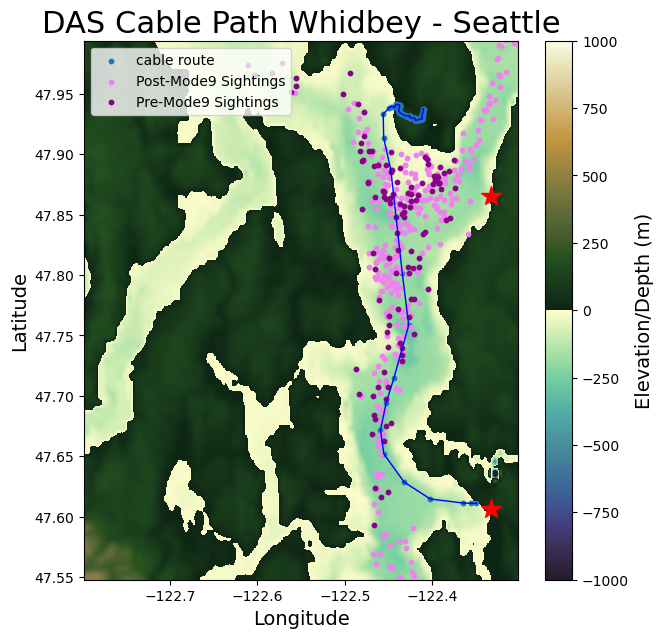

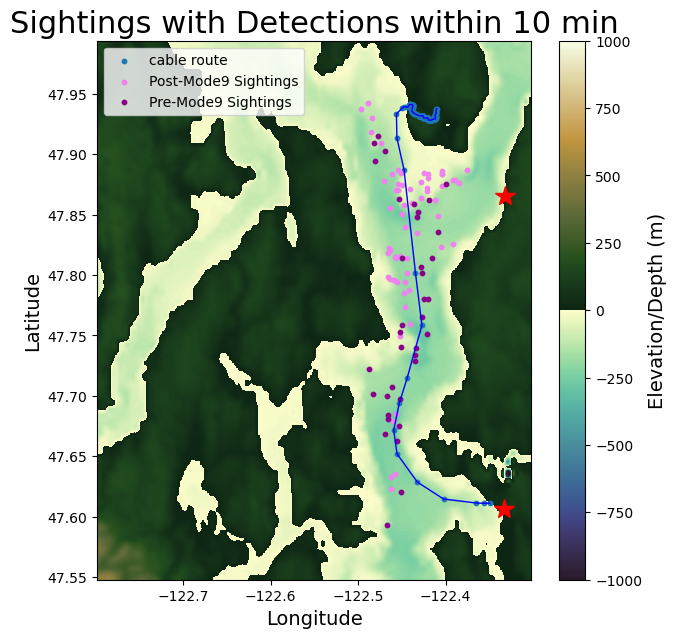

In [4]:
lat = [47.55, 48]
long = [-122.8, -122.3]

mode9_cablelats = []
mode9_cablelongs = []

bathy = gebco_load(lat, long)

sights = srkw_sightings(lat, long)
detects = sunset_bay_detections()
print(len(detects))

minutes = 30
matched_s = matching_sights_sounds(sights, detects, minutes)
matched_d = matching_sights_sounds(detects, sights, minutes)
print(matched_s)

plot_bathy(bathy, sights, mode9_cablelats, mode9_cablelongs, title='DAS Cable Path Whidbey - Seattle')
plot_bathy(bathy, matched_d, mode9_cablelats, mode9_cablelongs, title='Sightings with Detections within 10 min') 

Redo the whole thing at a tinier chunk up by mode 9

dict_keys(['Latitude', 'Longitude', 'Elevation'])


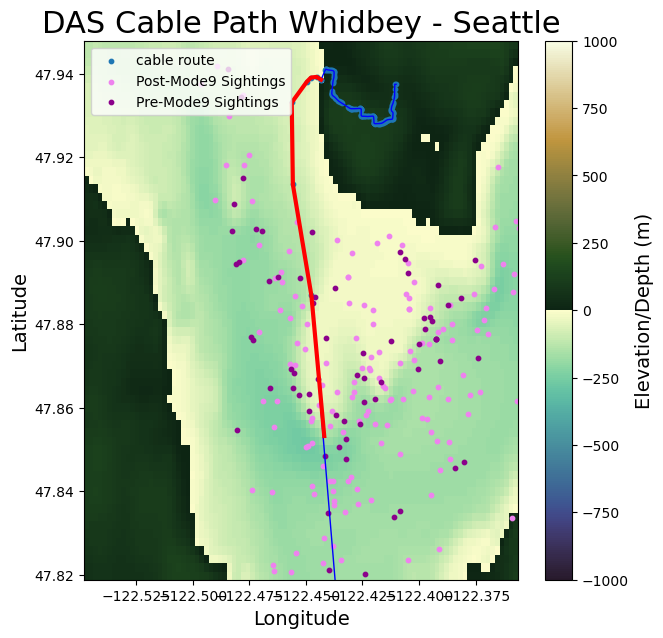

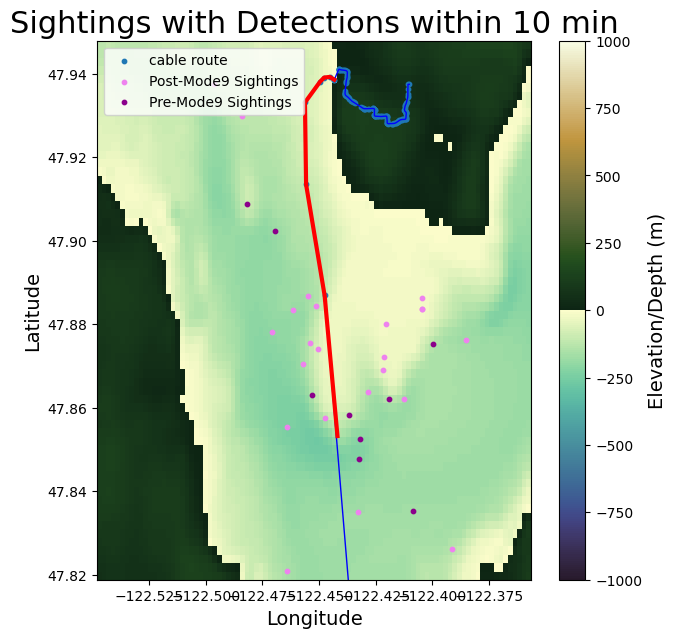

In [6]:
lat = [47.82, 47.95]
long = [-122.55, -122.35]

bathy = gebco_load(lat, long)

sights = srkw_sightings(lat, long)
detects = sunset_bay_detections()

mode9_cablelats = [47.938588224, 47.939247329, 47.939086368, 47.938112322, 47.93311287, 47.913462193, 47.886871002, 47.85318389231053]  
mode9_cablelongs = [-122.443303496, -122.445259957, -122.447750044, -122.449542984, -122.456240323, -122.455741775, -122.44756012, -122.44188688856443]

minutes = 10
matched_s = matching_sights_sounds(sights, detects, minutes)        # the audio that has visual sightings within 10 min
matched_d = matching_sights_sounds(detects, sights, minutes)    # the visual sightings that have audio within 10 min

plot_bathy(bathy, sights, mode9_cablelats, mode9_cablelongs, title='DAS Cable Path Whidbey - Seattle')
plot_bathy(bathy, matched_d, mode9_cablelats, mode9_cablelongs, title='Sightings with Detections within 10 min') 

matched_s['utc_date_time'] = matched_s['utc_date_time'].dt.tz_localize(None)
matched_s.to_excel("matched_detects_to_visuals.xlsx", index=False)  # index=False to exclude the index column
